# Introduction

This project aims to develop a set of predictive model for monitoring and optimizing water quality in freshwater aquaponics systems dedicated to catfish farming. By leveraging IoT sensor data and machine learning techniques, we analyze key environmental and biological factors influencing water health and fish well-being. Our system integrates real-time data collection from twelve aquaponics ponds, each monitored by an ESP-32 microcontroller equipped with sensors measuring parameters such as turbidity, temperature, ammonia, nitrate, dissolved oxygen, and pH.

The *Sensor Based Aquaponics Fish Pond Datasets*$\text{}^{1}$ consists of time-series records spanning from June to mid-October 2021, collected from twelve aquaponics ponds. Each pond is monitored individually, with IoT units capturing data every five minutes. These measurements provide insights into the complex interactions between water conditions and fish health, enabling predictive analytics for early issue detection and improved aquaponics management.

Key Variables in the Dataset:

- **Date/Time:** Timestamp of the recorded data.
- **Temperature:** Water temperature in degrees Celsius.
- **Turbidity:** Cloudiness or haziness of the water due to suspended particles.
- **Dissolved Oxygen (DO):** Oxygen available in water, essential for fish respiration and aerobic microbial processes.
- **pH:** Acidity or alkalinity of the water, crucial for maintaining optimal conditions.
- **Ammonia:** Concentration of ammonia, a byproduct of fish waste and organic matter decomposition.
- **Nitrate:** End-product of the nitrification process, impacting plant and microbial interactions.
- **Fish Population:** Number of fish in the pond at the time of measurement.
- **Fish Length:** Length of individual fish, indicating growth trends.
- **Fish Weight:** Mass of individual fish, reflecting health and development.

# Library Imports and Functions

In [7]:
# import necessary libraries
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import DomainWarning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import keras
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.utils import pad_sequences
from keras import optimizers
import warnings
from sklearn.metrics import mean_squared_error as mse
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('future.no_silent_downcasting', True)
warnings.filterwarnings('ignore', category=FutureWarning, module='statsmodels.genmod.families.links')
warnings.filterwarnings("ignore", category=DomainWarning)


# Data Loading and Initial Overview

In [9]:
# load IoT dataset
pond1_raw = pd.read_csv('data/archive/IoTPond1.csv')

# Google Cloud Load
# pond1_raw = pd.read_csv('./data')

pond1_raw.head()

,created_at,entry_id,Temperature (C),Turbidity(NTU),Dissolved Oxygen(g/ml),PH,Ammonia(g/ml),Nitrate(g/ml),Population,Fish_Length(cm),Fish_Weight(g)
0,2021-06-19 00:00:05 CET,1889,24.8750,100,4.505,8.43365,0.45842,193,50,7.11,2.91
1,2021-06-19 00:01:02 CET,1890,24.9375,100,6.601,8.43818,0.45842,194,50,7.11,2.91
2,2021-06-19 00:01:22 CET,1891,24.8750,100,15.797,8.42457,0.45842,192,50,7.11,2.91
3,2021-06-19 00:01:44 CET,1892,24.9375,100,5.046,8.43365,0.45842,193,50,7.11,2.91
4,2021-06-19 00:02:07 CET,1893,24.9375,100,38.407,8.40641,0.45842,192,50,7.11,2.91


In [10]:
pond1_raw.shape

(83126, 11)

In [11]:
pond1_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83126 entries, 0 to 83125
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   created_at              83126 non-null  object 
 1   entry_id                83126 non-null  int64  
 2   Temperature (C)         83126 non-null  float64
 3   Turbidity(NTU)          83126 non-null  int64  
 4   Dissolved Oxygen(g/ml)  83126 non-null  float64
 5   PH                      83126 non-null  float64
 6   Ammonia(g/ml)           83074 non-null  float64
 7   Nitrate(g/ml)           83126 non-null  int64  
 8   Population              83126 non-null  int64  
 9   Fish_Length(cm)         83124 non-null  float64
 10  Fish_Weight(g)          83124 non-null  float64
dtypes: float64(6), int64(4), object(1)
memory usage: 7.0+ MB


# Data Cleaning

In [13]:
# create a deep copy of the raw data
pond1 = pond1_raw.copy()

In [14]:
# convert 'created_at' to datetime format
pond1['created_at'] = pd.to_datetime(pond1['created_at'],
                                     errors='coerce') # if invalid date, replace with `NaT`
# check for invalid dates
print(f"Rows with invalid dates: { pond1['created_at'].isna().sum() }")

Rows with invalid dates: 0


In [15]:
# rename columns for easy reference
pond1.rename(columns={
    'created_at': 'datetime',
    'Temperature (C)': 'temperature',
    'Turbidity(NTU)': 'turbidity',
    'Dissolved Oxygen(g/ml)': 'dissolved_oxygen',
    'PH':'ph',
    'Ammonia(g/ml)': 'ammonia',
    'Nitrate(g/ml)': 'nitrate',
    'Population': 'population',
    'Fish_Length(cm)': 'fish_length',
    'Fish_Weight(g)': 'fish_weight'
}, inplace=True)

# set 'datetime' as the index for time-series analysis
pond1.set_index('datetime', inplace=True)

print(f"Renamed columns: { pond1.columns.tolist() }")

Renamed columns: ['entry_id', 'temperature', 'turbidity', 'dissolved_oxygen', 'ph', 'ammonia', 'nitrate', 'population', 'fish_length', 'fish_weight']


In [16]:
# replace missing values with column-wise mean
pond1.fillna(pond1.mean(), inplace=True)
print("Missing values replaced by column-wise mean")

# # remove missing values
# n_before = pond1.shape[0] # number of rows before dropping NaN values
# pond1.dropna(inplace=True) # drop missing values
# n_after = pond1.shape[0] # Get the number of rows after dropping NaN values

# print(f"Number of rows deleted: {n_before - n_after}")

Missing values replaced by column-wise mean


<Axes: >

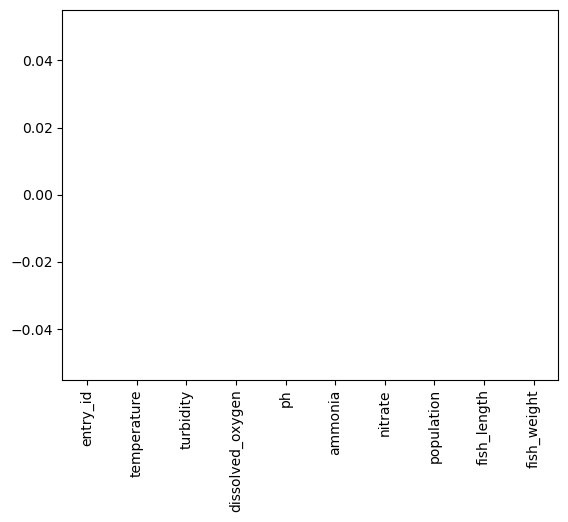

In [17]:
pond1.isna().sum().plot.bar()

In [18]:
pond1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 83126 entries, 2021-06-19 00:00:05 to 2021-10-13 04:14:22
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   entry_id          83126 non-null  int64  
 1   temperature       83126 non-null  float64
 2   turbidity         83126 non-null  int64  
 3   dissolved_oxygen  83126 non-null  float64
 4   ph                83126 non-null  float64
 5   ammonia           83126 non-null  float64
 6   nitrate           83126 non-null  int64  
 7   population        83126 non-null  int64  
 8   fish_length       83126 non-null  float64
 9   fish_weight       83126 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 7.0 MB


In [19]:
pond1.head()

,entry_id,temperature,turbidity,dissolved_oxygen,ph,ammonia,nitrate,population,fish_length,fish_weight
datetime,,,,,,,,,,
2021-06-19 00:00:05,1889,24.8750,100,4.505,8.43365,0.45842,193,50,7.11,2.91
2021-06-19 00:01:02,1890,24.9375,100,6.601,8.43818,0.45842,194,50,7.11,2.91
2021-06-19 00:01:22,1891,24.8750,100,15.797,8.42457,0.45842,192,50,7.11,2.91
2021-06-19 00:01:44,1892,24.9375,100,5.046,8.43365,0.45842,193,50,7.11,2.91
2021-06-19 00:02:07,1893,24.9375,100,38.407,8.40641,0.45842,192,50,7.11,2.91


# Exploratory Data Analysis (EDA)

In [21]:
pond1.describe()

,entry_id,temperature,turbidity,dissolved_oxygen,ph,ammonia,nitrate,population,fish_length,fish_weight
count,83126.000000,83126.000000,83126.000000,83126.000000,83126.000000,8.312600e+04,83126.000000,83126.0,83126.000000,83126.000000
mean,84018.144516,24.573376,87.490160,12.390251,7.518329,2.030817e+08,458.294408,50.0,16.414686,44.568470
std,53579.484245,0.861532,25.859375,12.518253,0.534787,7.863770e+09,338.313206,0.0,5.272180,33.215091
min,1889.000000,-127.000000,1.000000,0.007000,-0.586270,6.770000e-03,45.000000,50.0,7.110000,2.910000
25%,24902.250000,24.125000,91.000000,3.440000,7.153520,4.584200e-01,146.000000,50.0,11.790000,14.190000
50%,103478.500000,24.562500,100.000000,7.133000,7.357790,6.139700e-01,347.000000,50.0,18.080000,54.700000
75%,131074.750000,24.937500,100.000000,15.819000,7.838980,1.565161e+01,823.000000,50.0,21.000000,67.520000
max,247405.000000,27.750000,100.000000,41.046000,8.551670,4.270000e+11,1936.000000,50.0,33.450000,318.640000


### Define variables

In [81]:
# without population since its a contant value
vars = ['temperature', 'turbidity', 'dissolved_oxygen', 'ph', 'ammonia', 'fish_length', 'fish_weight','nitrate']

### Data Dristribution and Trends

#### Histrograms

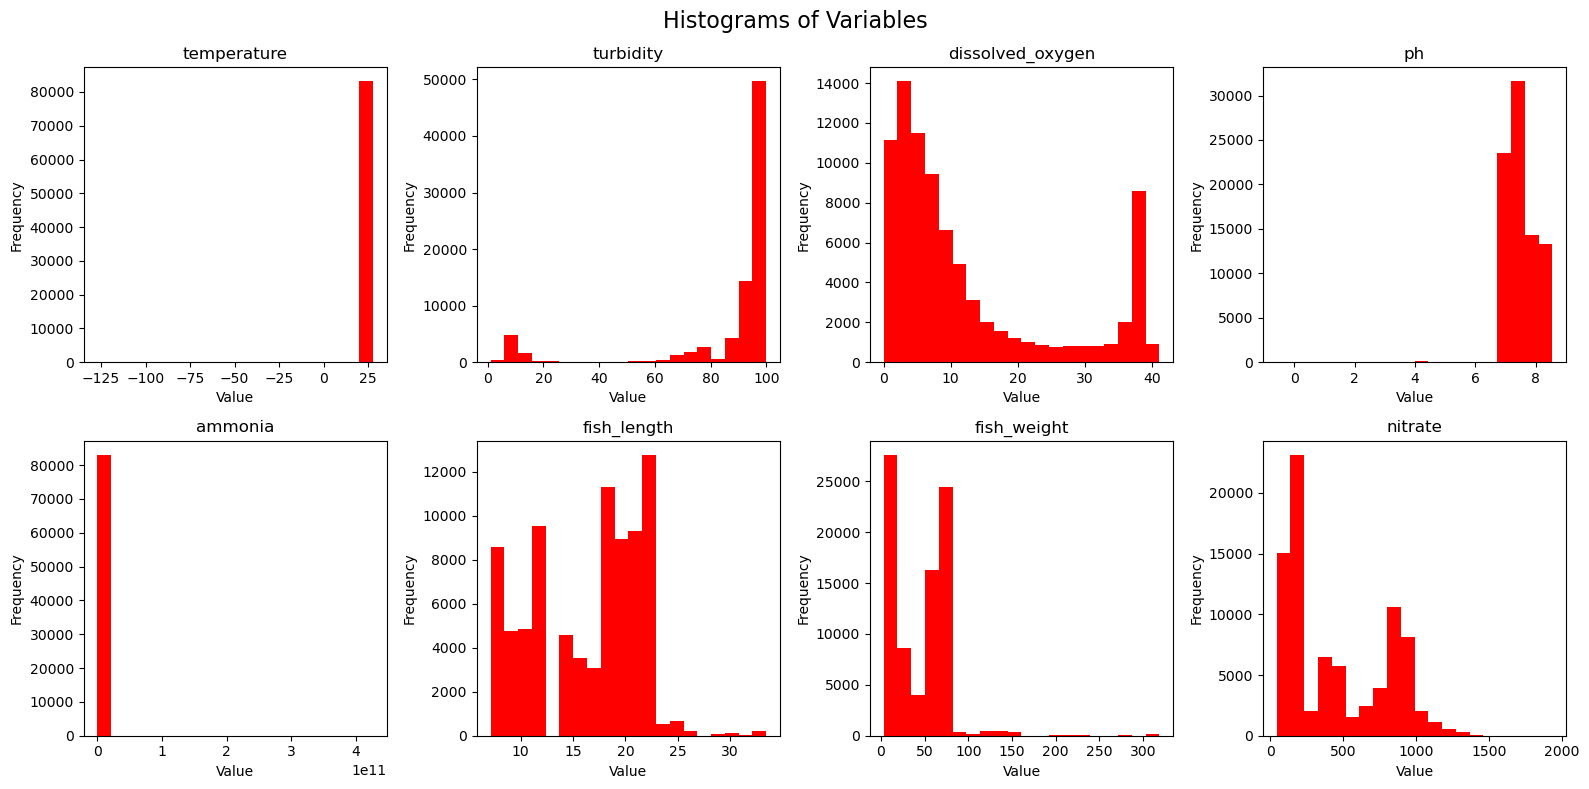

In [26]:
# set grid and size
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
fig.suptitle("Histograms of Variables", fontsize=16)

# flatten axes for easy iteration
axes = axes.flatten()

# create each histogram
for i, col in enumerate(vars):
    axes[i].hist(pond1[col], bins=20, color='red')
    axes[i].set_title(col)
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")

# adjusts spacing
plt.tight_layout()
plt.show()

#### Visual Representation

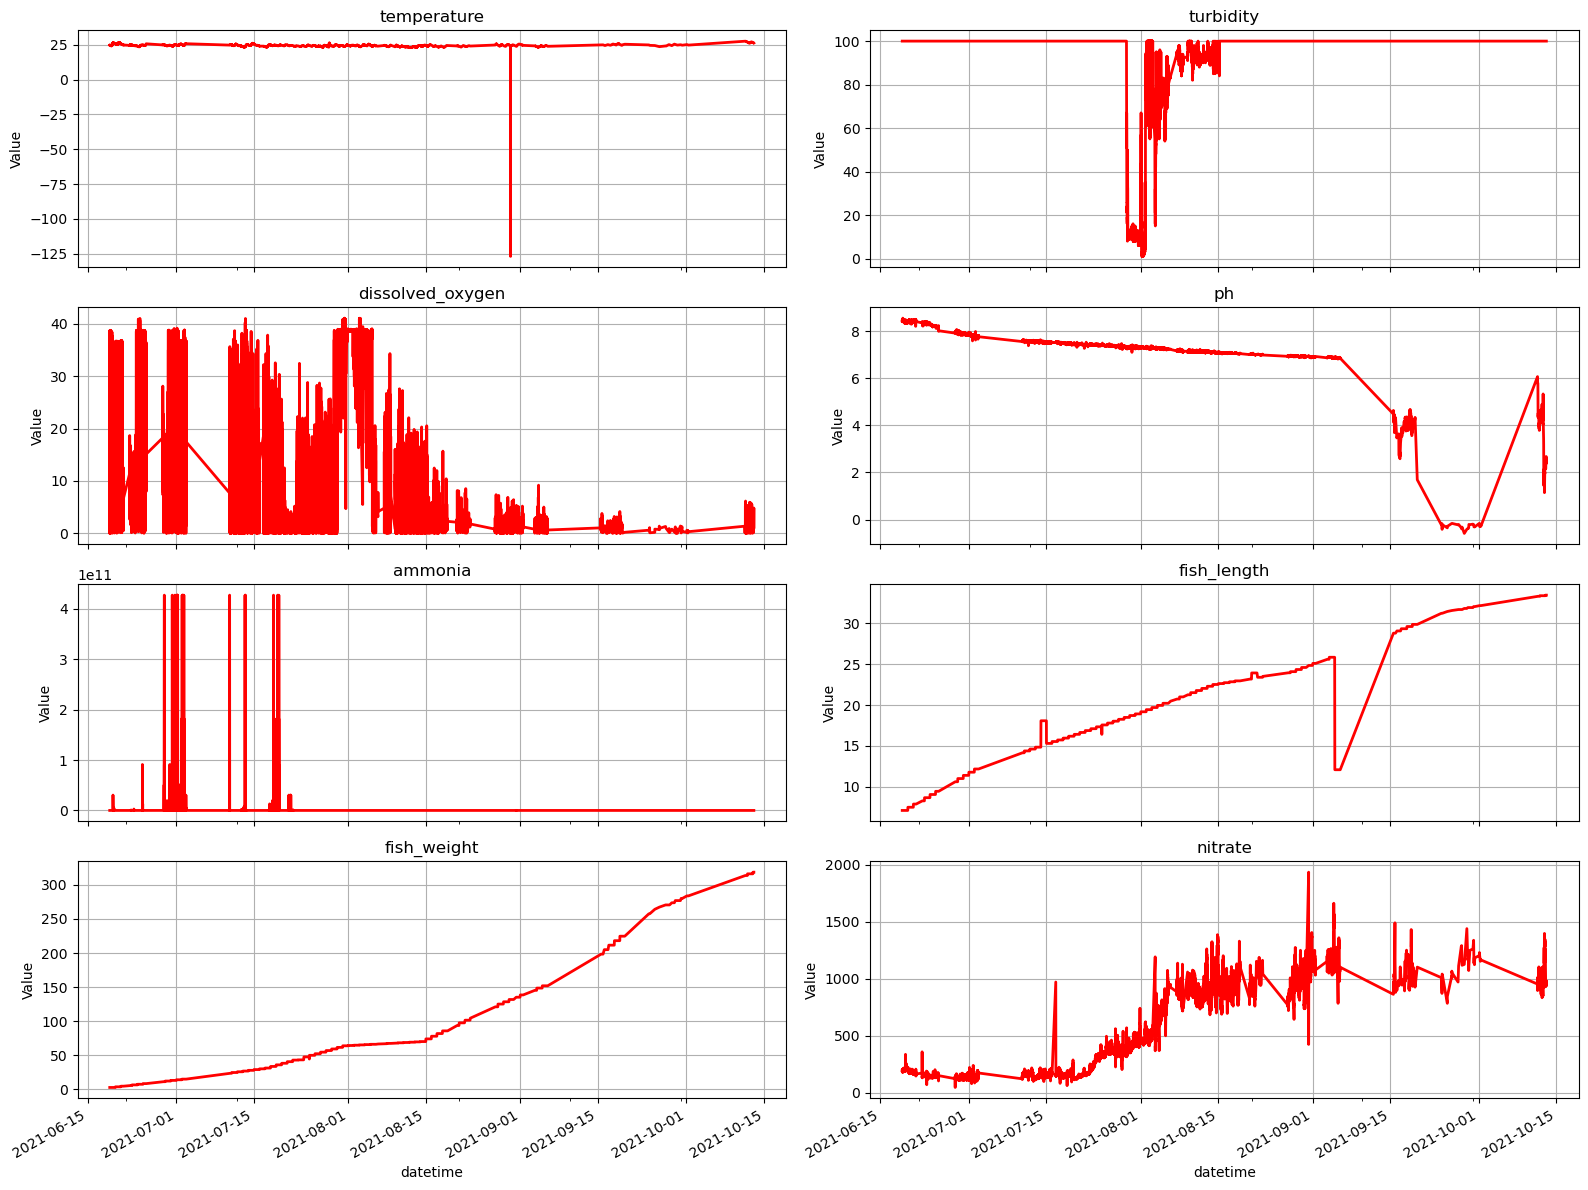

In [28]:
# set grid and size
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 12), sharex=True)

# flatten axes for easy iteration
axes = axes.flatten()

# create subplots for each variables
for i, col in enumerate(vars):
    pond1[col].plot(ax=axes[i], title=col, linewidth=2, color='red')
    axes[i].set_ylabel("Value")
    axes[i].grid(True)  # add grid for better readability

# remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# adjusts spacing
plt.tight_layout()
plt.show()

## Handle Outliers

In [30]:
# Assuming df is your DataFrame
Q1 = pond1.quantile(0.25)
Q3 = pond1.quantile(0.75)
IQR = Q3 - Q1

# Define the outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to remove outliers
pond1_filtered = pond1[~((pond1 < lower_bound) | (pond1 > upper_bound)).any(axis=1)]

print("Outliers replaced by interpolating between known values.")

Outliers replaced by interpolating between known values.


In [31]:
### Missing Data Interpolation
# Given timedelta
td = pond1_filtered['entry_id'].idxmax()-pond1_filtered['entry_id'].idxmin()

# Get total seconds
total_seconds = td.total_seconds()

# Calculate the number of 20-second intervals
intervals = total_seconds // 20  # Floor division to get whole intervals

print(f"Total 20-second intervals: {int(intervals)}")

full_range = pd.date_range(start=pond1_filtered.index.min(), end=pond1_filtered.index.max(), freq='20S')
pond1_filled = pond1_filtered.reindex(full_range).interpolate()
timeStep=20 ## 20 seconds
freqPerMinute=3
valuesPerDay=freqPerMinute*60*24
print("Values to be collected per day",valuesPerDay)
print("Total Values Expected", intervals)
print("Actual Values", pond1_filtered.shape[0])
print("Interpolated",pond1_filled.shape[0])
pond1_filled.resample('5T').mean()
pond1_2_min=pond1_filled.resample('2T').mean()

Total 20-second intervals: 332619
Values to be collected per day 4320
Total Values Expected 332619.0
Actual Values 49144
Interpolated 332620


In [32]:
pond1_filtered=pond1_2_min

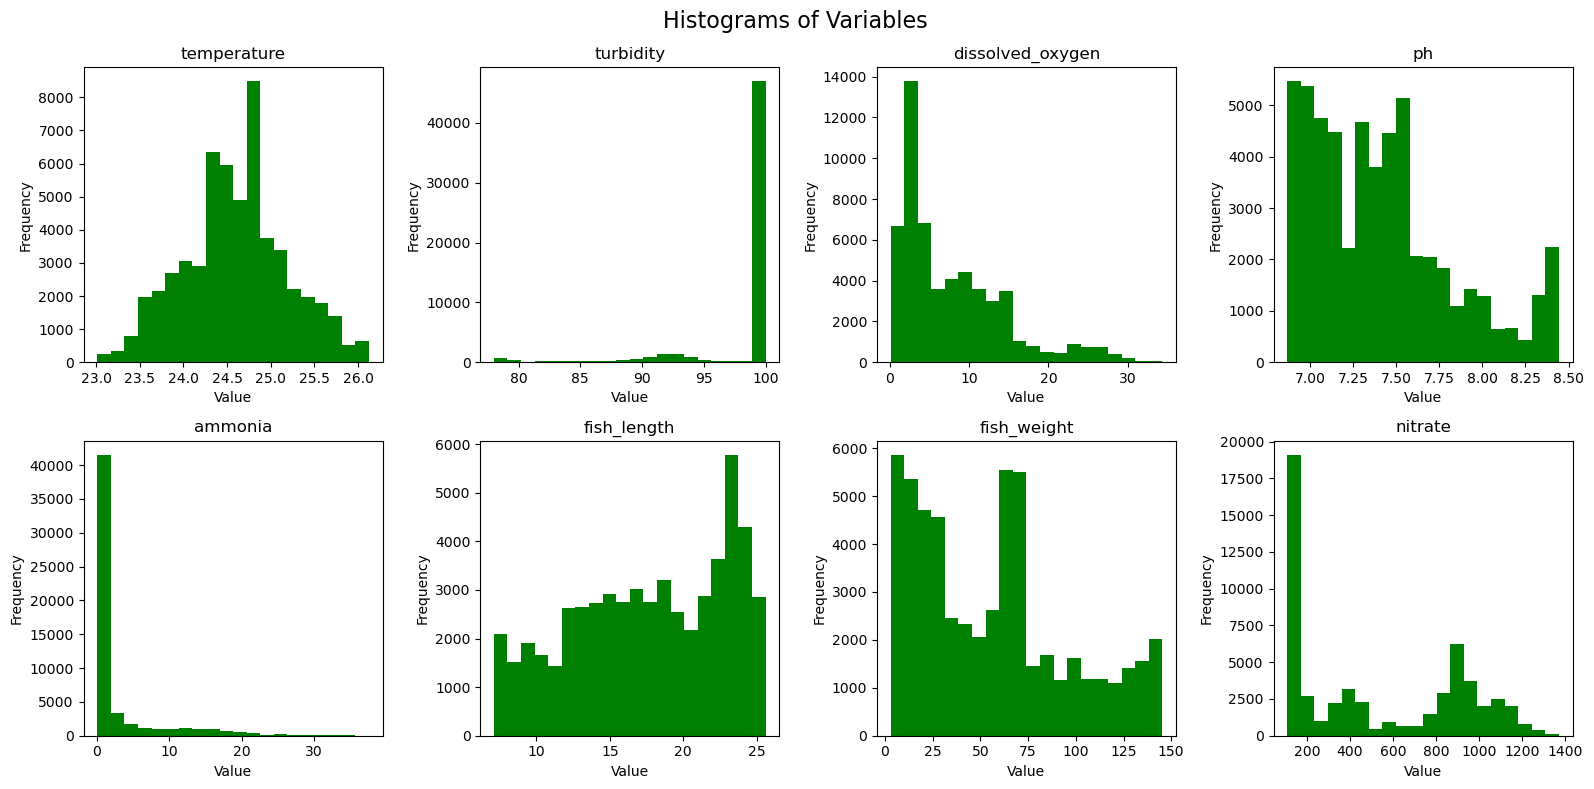

In [33]:
# set grid and size
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
fig.suptitle("Histograms of Variables", fontsize=16)

# flatten axes for easy iteration
axes = axes.flatten()

# create each histogram
for i, col in enumerate(vars):
    axes[i].hist(pond1_filtered[col], bins=20,  color='green')
    axes[i].set_title(col)
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")

# adjusts spacing
plt.tight_layout()
plt.show()

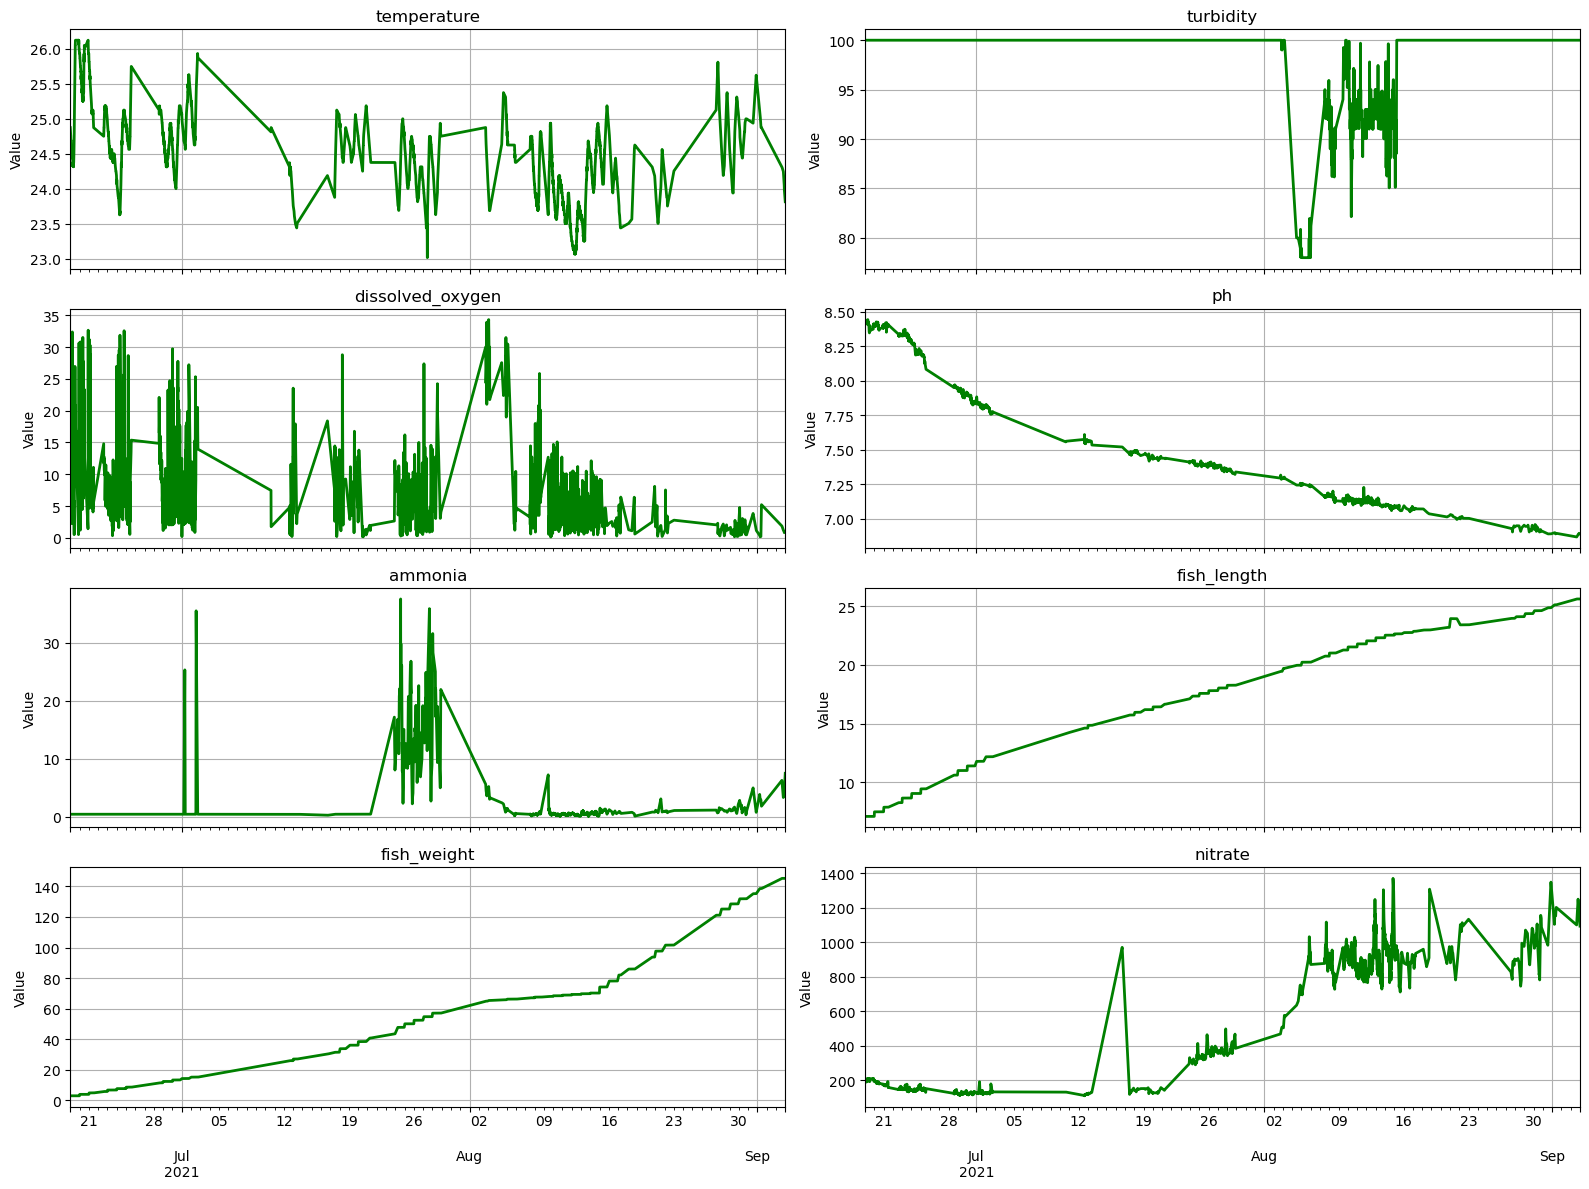

In [34]:
# set grid and size
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 12), sharex=True)

# flatten axes for easy iteration
axes = axes.flatten()

# create subplots for each variables
for i, col in enumerate(vars):
    pond1_filtered[col].plot(ax=axes[i], title=col, linewidth=2, color='green')
    axes[i].set_ylabel("Value")
    axes[i].grid(True)  # add grid for better readability

# remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# adjusts spacing
plt.tight_layout()
plt.show()

### Monthly Average

In [36]:
# group by 'datetime' with monthly frequency
pond1_monthly_avg = pond1_filtered.groupby(pd.Grouper(freq='M'))[vars].mean()
pond1_monthly_avg.head()

,temperature,turbidity,dissolved_oxygen,ph,ammonia,fish_length,fish_weight,nitrate
2021-06-30,25.041968,100.000000,10.865913,8.165842,0.458420,9.249757,8.067363,148.620156
2021-07-31,24.656725,100.000000,8.387896,7.519863,5.285965,15.468348,34.128379,257.628697
2021-08-31,24.382704,96.063068,6.452957,7.079667,1.573281,22.354435,87.884041,893.760443
2021-09-30,24.617753,100.000000,2.863938,6.883691,3.988503,25.337710,141.785316,1157.510421


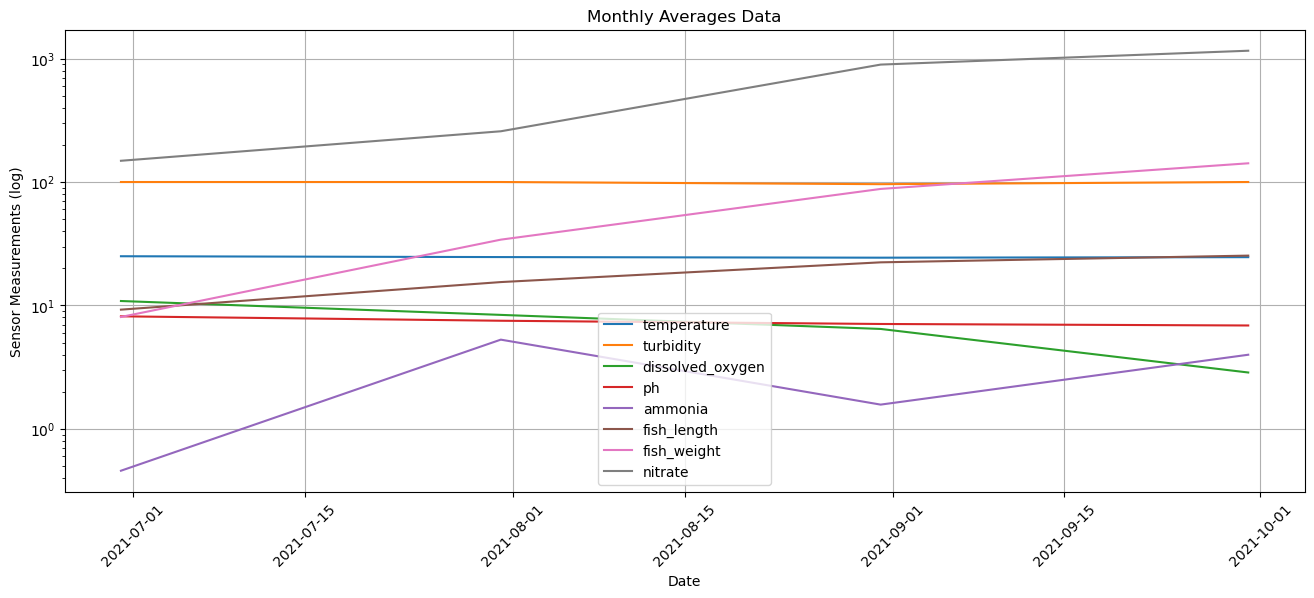

In [37]:
# plot each variable
plt.figure(figsize=(16, 6))
for column in vars:
    plt.plot(pond1_monthly_avg.index,  # months
             pond1_monthly_avg[column],  # monthly average
             label=column)

plt.title('Monthly Averages Data')
plt.xlabel('Date')
plt.ylabel('Sensor Measurements (log)')
plt.yscale('log')  # log scale for readability
plt.legend()
plt.xticks(rotation=45)  # for better visibility
plt.grid(True)
plt.show()

### Data Correlation

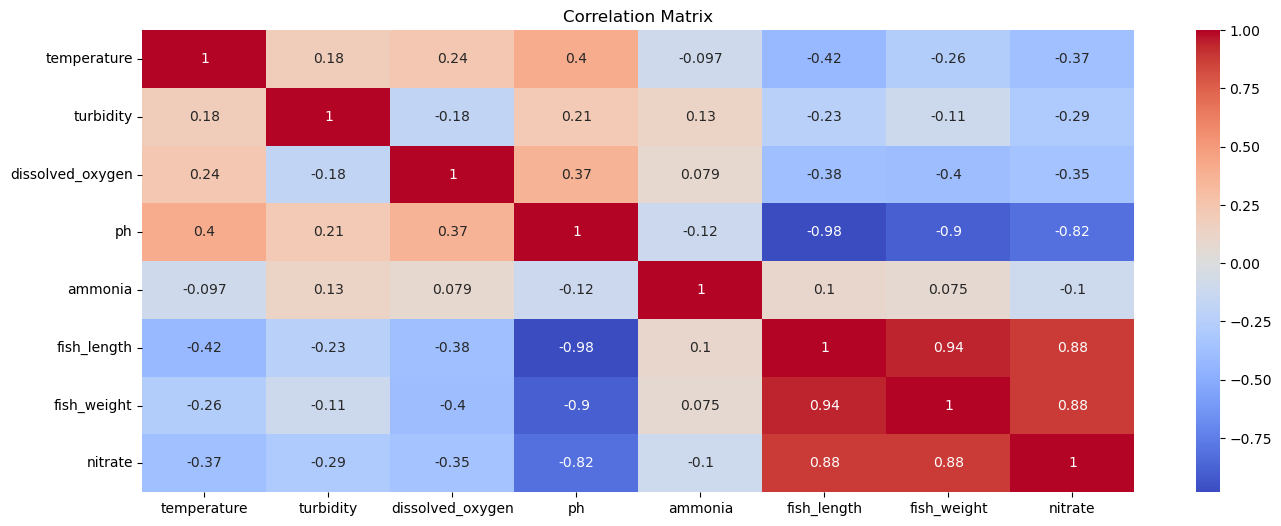

In [39]:
# compute correlation matrix
corr_matrix = pond1_filtered[vars].corr()

# display heatmap
plt.figure(figsize=(16, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Feature Selection
* There are 8 features in the original data set
* For predicting Fish Length,  Correlation Matrix shows  Fish Weight, Ammonia, Nitrate, Temperature and PH has strong correlations with  Fish length.  Since Fish Weight is the observed variable, we can ignore .
* For time series, prediction we can use Fish length/Fish Weight but these are not IOT data . We can control nitrate value and  predict it for the future

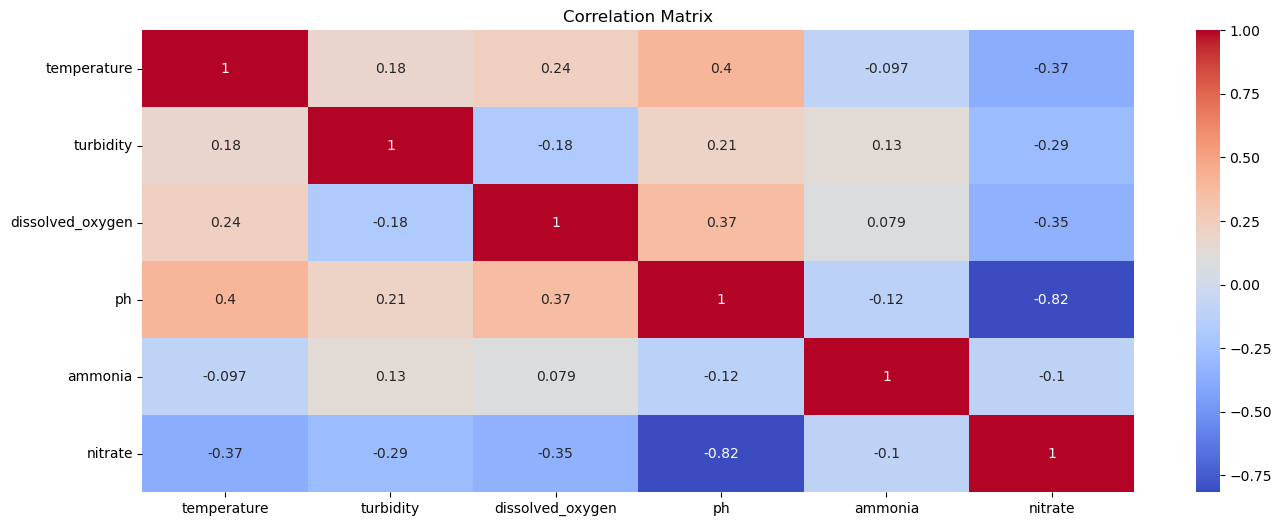

In [41]:
features_for_prediction = ['temperature', 'turbidity', 'dissolved_oxygen', 'ph', 'ammonia','nitrate']
corr_matrix = pond1_filtered[features_for_prediction].corr()

# display heatmap
plt.figure(figsize=(16, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

            PC1       PC2
0      3.665891 -0.270186
1      3.675067 -0.246263
2      3.684243 -0.222340
3      3.693419 -0.198418
4      3.702595 -0.174495
...         ...       ...
55432 -3.809848 -1.074666
55433 -3.809964 -1.077733
55434 -3.809985 -1.078291
55435 -3.809985 -1.078291
55436 -3.809985 -1.078291

[55437 rows x 2 columns]
Explained Variance Ratio: [0.56744737 0.13466392]


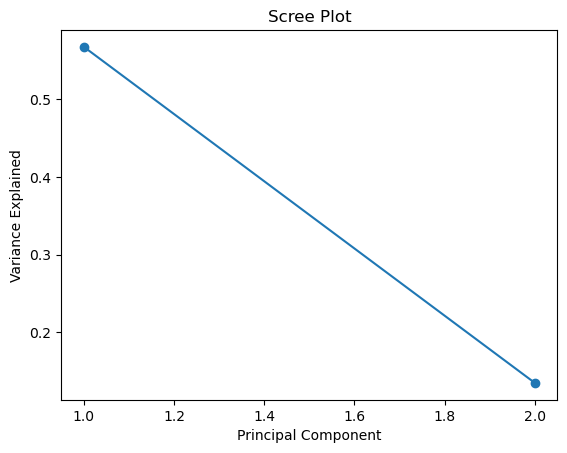

In [42]:
scaler = StandardScaler()
pond_scaled = scaler.fit_transform(pond1_filtered)

# 2. Applying PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions
principal_components = pca.fit_transform(pond_scaled)

# 3. Convert to DataFrame
df_pca = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])
print(df_pca)

# 4. Explained Variance Ratio
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# 5. Scree Plot (to decide optimal components)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Scree Plot')
plt.show()

#### Feature Selection
* There are 8 features in the original data set
* For predicting Fish Length,  Correlation Matrix shows  Fish Weight, Ammonia, Nitrate, Temperature and PH has strong correlations with  Fish length.  Since Fish Weight is the observed variable, we can ignore .
* For time series, prediction we can use Fish length/Fish Weight but these are not IOT data . We can control nitrate value and  predict it for the future

# Machine Learning Models

##### Objective
 **Prediction of Ph value of the pond for the next 10th minute using the  PH Sensor Data from the pond**

In [75]:
predicted_feature='ph'

In [77]:
pond1_filtered['unix'] = pd.to_datetime( pond1_filtered.index).astype('int64')/1e9  

In [28]:
train_size = int(len(pond1_filtered[predicted_feature]) * 0.8)
train, test = pond1_filtered[['unix',predicted_feature]].iloc[:train_size], pond1_filtered[['unix',predicted_feature]].iloc[train_size:]

print(f"Train Size: {len(train)}, Test Size: {len(test)}")

Train Size: 44349, Test Size: 11088


## Traditional

**Linear Regression Model**

Prediction of Ph at 10th minute(5 th Time Step) from the Ph sensor reading

In [29]:

ts=pd.DataFrame(train['unix'])
ys=pd.DataFrame(train[predicted_feature])
ph = 5 # Since time step is 2 mins, 5 steps required to predict 10th min
ph_index = 5
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000


In [30]:
def train_and_predict(ts,ys,mu):
    tp_pred = np.zeros(n_s) 
    yp_pred = np.zeros(n_s)
    for i in range(2,n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
        ts_tmp = ts[0:i]
        ys_tmp = ys[0:i]
        ns = len(ys_tmp)
        
        weights = np.ones(ns)*mu
        for k in range(ns):
            #adjust weights to be downweighted according to their timestep away from our prediction
            weights[k] = weights[k]**k
        weights = np.flip(weights, 0)
            
        #perform linear regression on "available" data using the mu-adjusted weights
        lm_tmp = LinearRegression()
        model_tmp = lm_tmp.fit(ts_tmp,ys_tmp,sample_weight=weights)
        
        #store model coefficients and intercepts to compute prediction
        m_tmp = model_tmp.coef_
        q_tmp = model_tmp.intercept_

        #use ph to make the model prediction according to the prediction time
        tp = ts.iloc[ns+ph_index,0]
        yp = m_tmp*tp+q_tmp
        tp_pred[i-2] = tp    
        yp_pred[i-2] = yp[0,0]
    return tp_pred,yp_pred

In [31]:
    
def plotData(ys,yp_pred,mu,first,window=1000,title="Prediction"):
    #Plot first 200 data points/predictions
    fig, ax = plt.subplots(figsize=(12,6))
    fig.suptitle(title, fontsize=22, fontweight='bold')
    ax.set_title('mu = %g' %(mu))
    if first== True:
        ax.plot(train.index.values[ph_index:window+ph_index], yp_pred[0:window], label=f'Predicted {predicted_feature}') 
        ax.plot(train.index.values[ph_index:window+ph_index], ys.iloc[ph_index:window+ph_index,0], label=f'Actual {predicted_feature}') 
    else:
        ax.plot(train.index.values[n_s-window+ph_index:n_s+ph_index], yp_pred[-window:], label=f'Predicted {predicted_feature}') 
        ax.plot(train.index.values[n_s-window+ph_index:n_s+ph_index], ys.iloc[n_s-window+ph_index:n_s+ph_index,0], label=f'Actual {predicted_feature}') 
    ax.set_xlabel('time (CET)')
    ax.set_ylabel(f'{predicted_feature}(unit)')
    ax.legend()
    plt.show()

In [32]:
tp_pred,yp_pred=train_and_predict(ts,ys,mu=0.9)

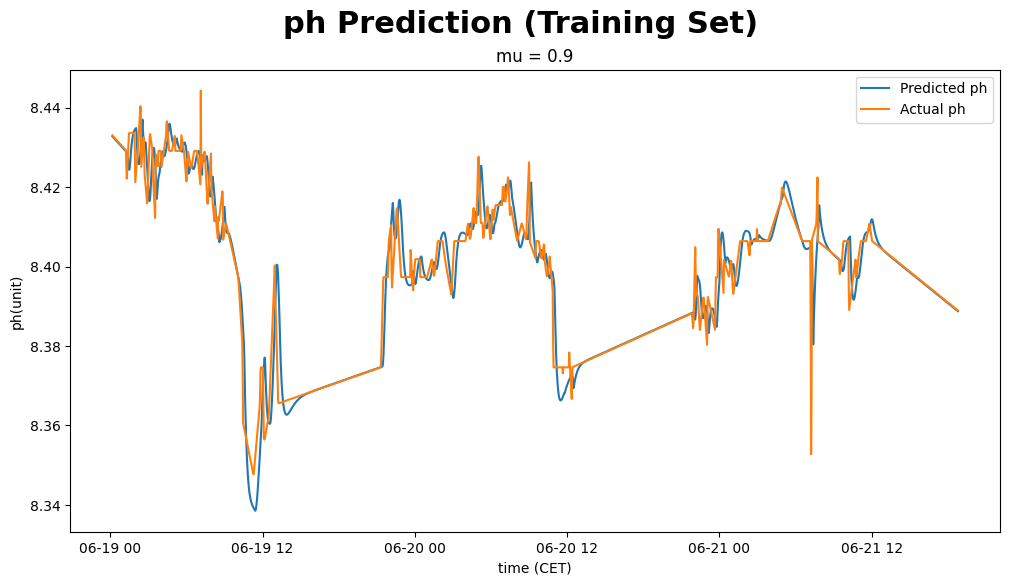

In [33]:
plotData(ys,yp_pred,mu=0.9,first=True,window=2000, title=f"{predicted_feature} Prediction (Training Set)")

In [34]:

ts=pd.DataFrame(test['unix'])
ys=pd.DataFrame(test[predicted_feature])
# one_min_in_epoch=train['unix'][1]-train['unix'][0]
ph = 5 #one_min_in_epoch #10 minutes
ph_index = 5
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

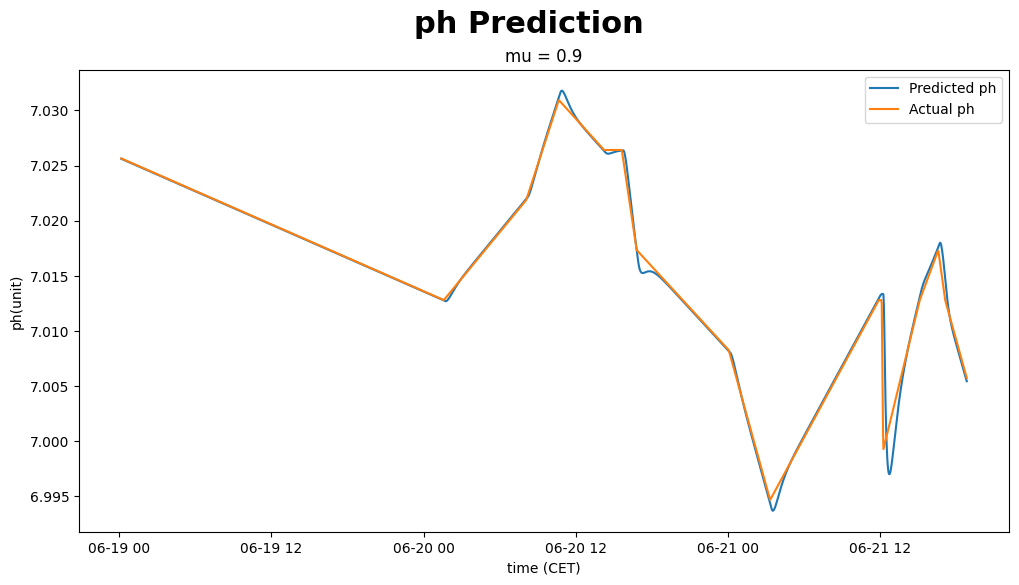

In [35]:
tp_pred,yp_pred=train_and_predict(ts,ys,mu=0.9)
plotData(ys,yp_pred,mu=0.9,first=True,window=2000, title=f"{predicted_feature} Prediction")


In [36]:
mean_squared_error_lm=mse(ys[:5000],yp_pred)
print(f"Linear Regression MSE : {np.round(mean_squared_error_lm,decimals=4)}")

Linear Regression MSE : 0.0097


##### Base Line
*  LinearRegression Model shows good performance.  But this is not the right way to fit a non linear data. 
*  **MSE produced on this method is 0.0097**

## Deep Learning

#### Predicting the next 10th min Ph value of the pond using LSTM

In [37]:
seq_length = 30
ph = 5

feat_cols = [predicted_feature]
seq_arrays=[]
seq_labs=[]
train_df_as_array=train[predicted_feature].values
#create list of sequence length GAP readings
for i in range(train.shape[0]-seq_length-ph):
    seq=[[j] for j in train_df_as_array[i:i+seq_length]]
    seq_arrays.append(seq)
    pred_val=train_df_as_array[i+seq_length+ph-1]
    seq_labs.append(pred_val)
    

#convert to numpy arrays and floats to appease keras/tensorflow        
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [50]:

model_path = 'LSTM_model1.keras'
# build the network
nb_features = 1
nb_out = 1
model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=20, 
         return_sequences=True))
model.add(Dropout(0.2)) 

# add second LSTM layer
model.add(LSTM(
          units=10,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
optimizer = optimizers.Adam(learning_rate = 0.0005)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

print(model.summary())

# fit the network
history = model.fit(seq_arrays,seq_labs, epochs=200, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=60, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

/Users/manikandanperumal/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 30, 20)         │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 10)             │         1,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,011 (11.76 KB)

 Trainable params: 3,011 (11.76 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/200
85/85 - 2s - 23ms/step - loss: 40.4035 - mse: 40.4035 - val_loss: 17.5600 - val_mse: 17.5600
Epoch 2/200
85/85 - 1s - 15ms/step - loss: 15.6414 - mse: 15.6414 - val_loss: 7.2654 - val_mse: 7.2654
Epoch 3/200
85/85 - 1s - 15ms/step - loss: 8.9266 - mse: 8.9266 - val_loss: 4.0645 - val_mse: 4.0645
Epoch 4/200
85/85 - 1s - 14ms/step - loss: 6.1424 - mse: 6.1424 - val_loss: 2.4157 - val_mse: 2.4157
Epoch 5/200
85/85 - 1s - 15ms/step - loss: 4.5397 - mse: 4.5397 - val_loss: 1.4061 - val_mse: 1.4061
Epoch 6/200
85/85 - 1s - 14ms/step - loss: 3.4388 - mse: 3.4388 - val_loss: 0.7713 - val_mse: 0.7713
Epoch 7/200
85/85 - 1s - 14ms/step - loss: 2.7152 - mse: 2.7152 - val_loss: 0.3843 - val_mse: 0.3843
Epoch 8/200
85/85 - 1s - 14ms/step - loss: 2.2118 - mse: 2.2118 - val_loss: 0.1646 - val_mse: 0.1646
Epoch 9/200
85/85 - 1s - 14ms/step - loss: 1.9184 - mse: 1.9184 - val_loss: 0.0520 - val_mse: 0.0520
Epoch 10/200
85/85 - 1s - 14ms/step - loss: 1.7323 - mse: 1.7323 - val_loss: 0.0

In [51]:
# Evaluate model and print results
y_pred = model.predict(seq_arrays)

# Inverse transform predictions and true values
# y_pred_inv = scaler_inputs.inverse_transform(y_pred)
# y_test_inv = scaler_inputs.inverse_transform(seq_labs.reshape(-1,1))

# Compute metrics
mse = mean_squared_error(y_pred, seq_labs)
rmse = np.sqrt(mse)

print("\nModel Performance:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

1385/1385 ━━━━━━━━━━━━━━━━━━━━ 1s 961us/step

Model Performance:
MSE: 0.0022
RMSE: 0.0469


1385/1385 - 1s - 907us/step - loss: 0.0022 - mse: 0.0022

MSE: 0.0022035420406609774
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 1s 889us/step


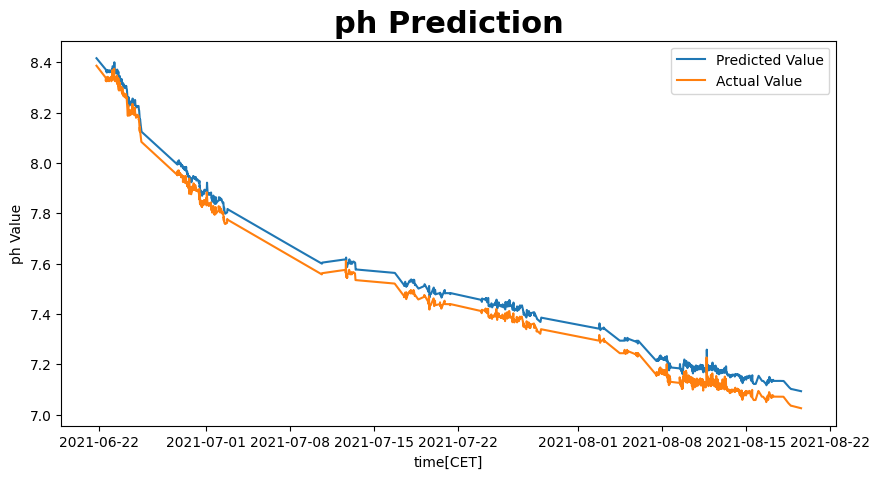

In [52]:
scores_test = model.evaluate(seq_arrays,seq_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(seq_arrays)
y_true_test = seq_labs


# Plot the predicted data vs. the actual data
# we will limit our plot to the first 500 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(train[seq_length+ph+2000:].index.values,y_pred_test[2000:], label = 'Predicted Value')
plt.plot(train[seq_length+ph+2000:].index.values,y_true_test[2000:], label = 'Actual Value')
plt.title(f'{predicted_feature} Prediction', fontsize=22, fontweight='bold')
plt.ylabel(f'{predicted_feature} Value')
plt.xlabel('time[CET]')
plt.legend()
plt.show()


In [53]:
val_arrays = []
val_labs = []

#create list of GAP readings starting with a minimum of two readings
ph = 5

feat_cols = [predicted_feature]

val_df_as_array=test[predicted_feature].values
#create list of sequence length GAP readings
for i in range(test.shape[0]-seq_length-ph):
    seq=[[j] for j in val_df_as_array[i:i+seq_length]]
    val_arrays.append(seq)
    pred_val=val_df_as_array[i+seq_length+ph-1]
    val_labs.append(pred_val)

# use the pad_sequences function on your input sequences
# remember that we will later want our datatype to be np.float32 
val_arrays = np.array(val_arrays, dtype = object).astype(np.float32)
#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

In [54]:
# Evaluate model and print results
y_pred = model.predict(val_arrays)


# Compute metrics
mse = mean_squared_error(y_pred, val_labs)
rmse = np.sqrt(mse)

print("\nModel Performance:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step

Model Performance:
MSE: 0.0062
RMSE: 0.0788


346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step


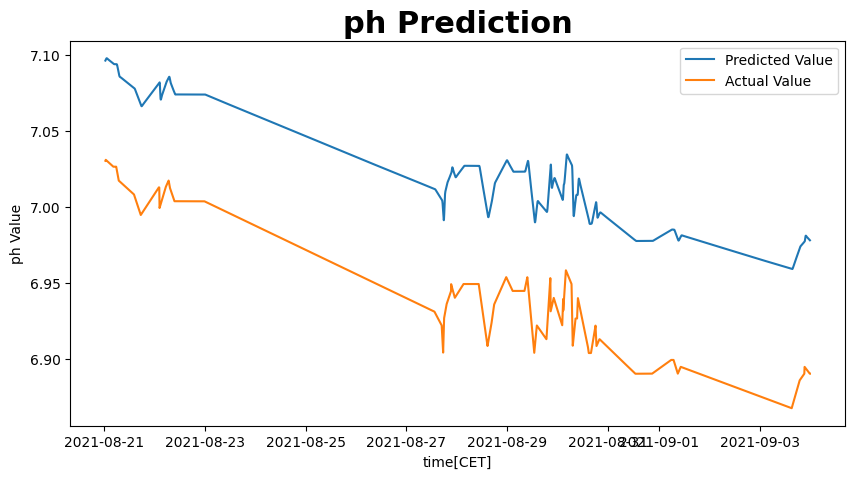

In [55]:
y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

window=1000
# Plot the predicted data vs. the actual data
# we will limit our plot to the first 500 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(ys[seq_length+ph+window:].index.values,y_pred_test[window:], label = 'Predicted Value')
plt.plot(ys[seq_length+ph+window:].index.values,y_true_test[window:], label = 'Actual Value')
plt.title(f'{predicted_feature} Prediction', fontsize=22, fontweight='bold')
plt.ylabel(f'{predicted_feature} Value')
plt.xlabel('time[CET]')
plt.legend()
plt.show()


#### Model Evaluation
Model :
|Layer (type)                     | Output Shape           |      Param # |
|---|---|----|
|  lstm_58 (LSTM)                  |(None, 30, 20)         |        1,760 |
|dropout_58 (Dropout)             | (None, 30, 20)         |           0 |
| lstm_59 (LSTM)                  |  (None, 10)            |         1,240 |
| dropout_59 (Dropout)            | (None, 10)             |             0 |
| dense_29 (Dense)                | (None, 1)              |            11 |

Hyper Parameters:
learning_rate = 0.0005

epochs=200,

batch_size=500,

validation_split=0.05, 

EarlyStopping(monitor='val_loss', min_delta=0, patience=60, verbose=0, mode='min'),

Model Performance:
|Metric |Score|
|-------|-----|
| MSE   | 0.0062|
| RMSE  |  0.0788|


#### Observation
 *  LSTM model has better MSE (0.0062) compared to Linear Regression Method

# Model Deployment

# Data Export


----------------
$^{1}$ Ogbuokiri, B. (2021). Sensor-based aquaponics fish pond datasets. Kaggle. https://www.kaggle.com/datasets/ogbuokiriblessing/sensor-based-aquaponics-fish-pond-datasets